## Week 11 Homework (9)

### Q1: copulas

1. ~~Use the example copula code below to provide posterior inference on the dependency structure between for **your own non normally distributed data that you find**~~
2. Repeat the exercise using instead a two pass approach in the manner of https://www.pymc.io/projects/examples/en/latest/howto/copula-estimation.html
3. Describe what a copula is and how the two verions of code implement it
4. Describe how to use this to create arbitrary multivariate GLM regressions

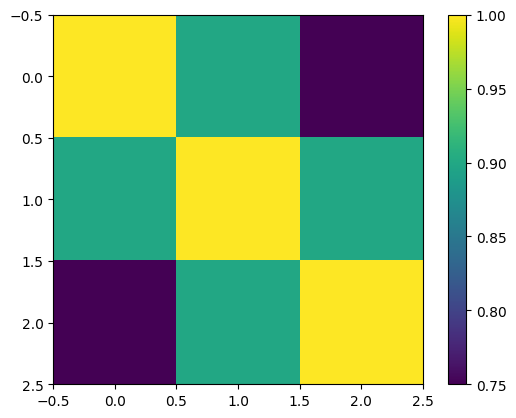

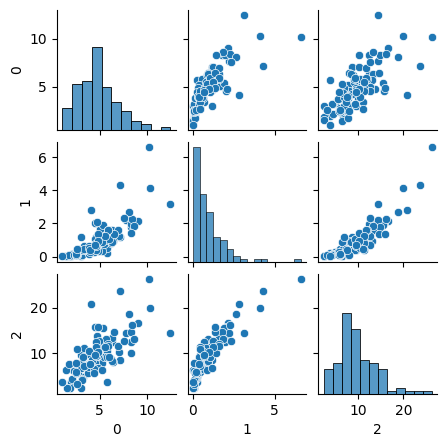

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

# --- STEP 1: Simulate Dependent Data with Non-Gaussian Marginals ---
p = 3
a_cor = (np.ones((p, p)) * 9 + np.diag((1, 1, 1))) / 10
a_cor[0, -1] -= 0.15
a_cor[-1, 0] -= 0.15

n = 100
x = stats.multivariate_normal(mean=np.zeros(p), cov=a_cor).rvs(size=n)
plt.imshow(a_cor)
plt.colorbar()

# break

# Transform marginals to non-Gaussian distributions
y = np.zeros_like(x)
y[:, 0] = stats.gamma(a=5).ppf(stats.norm().cdf(x[:, 0]))
y[:, 1] = stats.expon(scale=1).ppf(stats.norm().cdf(x[:, 1]))
y[:, 2] = stats.chi2(df=10).ppf(stats.norm().cdf(x[:, 2]))

sns.pairplot(pd.DataFrame(y), height=1.5)
plt.show()

Output()

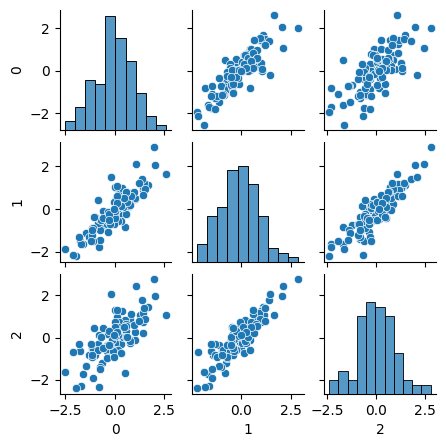

In [2]:
with pm.Model() as marginal_model:
    p0 = pm.HalfNormal("p0", sigma=10)
    y0 = pm.Gamma("y0", alpha=p0, beta=1, observed=y[:, 0])

    p1 = pm.HalfNormal("p1", sigma=10)
    y1 = pm.Exponential("y1", lam=p1, observed=y[:, 1])

    p2 = pm.HalfNormal("p2", sigma=10)
    y2 = pm.ChiSquared("y2", nu=p2, observed=y[:, 2])

    idata_marginals = pm.sample()

# Extract posterior means for estimated parameters
alpha_hat = idata_marginals.posterior["p0"].mean().item()
lambda_hat = idata_marginals.posterior["p1"].mean().item()
nu_hat = idata_marginals.posterior["p2"].mean().item()

# Transform observations into standard normal space
y0_trans = stats.norm.ppf(stats.gamma.cdf(y[:, 0], a=alpha_hat, scale=1))
y1_trans = stats.norm.ppf(stats.expon.cdf(y[:, 1], scale=lambda_hat))
y2_trans = stats.norm.ppf(stats.chi2.cdf(y[:, 2], df=nu_hat))

y_transformed = np.column_stack([y0_trans, y1_trans, y2_trans])

sns.pairplot(pd.DataFrame(y_transformed), height=1.5)
plt.show()

In [3]:
# --- STEP 3: Estimate Dependency Structure Using Copula ---
with pm.Model() as copula_model:
    L, R, stds = pm.LKJCholeskyCov(
        "R", n=3, eta=2.0, sd_dist=pm.Exponential.dist(1.0, shape=3), compute_corr=True
    )

    # Multivariate Normal likelihood on transformed observations
    copula_likelihood = pm.MvNormal(
        "copula", mu=np.zeros(3), cov=R, observed=y_transformed
    )

    idata_copula = pm.sample()

Output()

ERROR:pymc.stats.convergence:There were 292 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


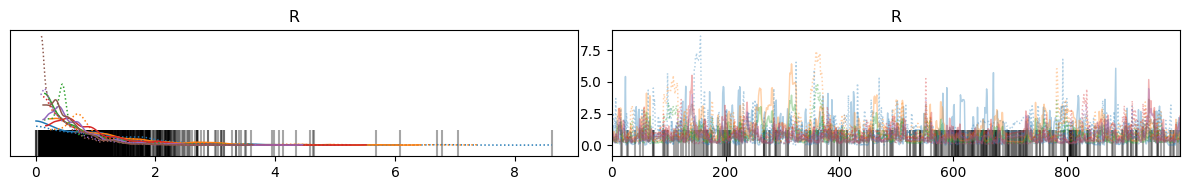

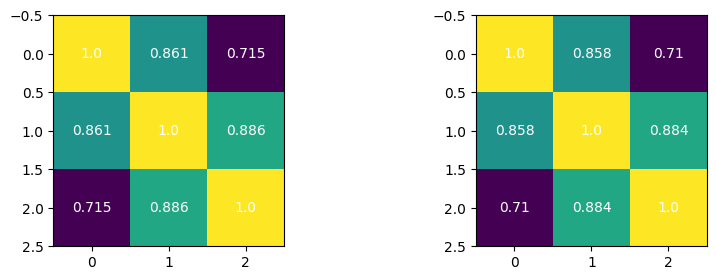

In [4]:
# --- STEP 4: Visualize Posterior Correlations ---
az.plot_trace(idata_copula, var_names=["R"])
plt.tight_layout()

fig, ax = plt.subplots(1, 2, figsize=(10, 3))  # Change from (1, 3) to (1, 2)
for i, c in enumerate(
    list(idata_copula.posterior["R_corr"].values.mean(axis=1))[:2]
):  # Only take first two
    ax[i].imshow(c)
    for k in range(3):
        for j in range(3):
            ax[i].text(
                j, k, s=str(round(c[j, k], 3)), color="w", va="center", ha="center"
            )

plt.show()

### 3. What is a Copula and How Do the Two Versions of Code Implement It?

A **copula** is a function that models the **dependency structure** between multiple random variables, independent of their marginal distributions. This is useful for handling **non-Gaussian** data while preserving dependency relationships.

#### Implementation in the Two Versions of Code:

1. **Original Approach (One-Pass)**  
   - Directly fits a **joint Bayesian model** with dependency encoded through an **LKJ prior** on the correlation matrix.  
   - Uses **transformed variables** via their CDFs to map them into standard normal space.  
   - The multivariate normal copula is applied **within the same model** as the marginals.  

2. **Two-Pass Approach**  
   - **First Pass:** Fits each **marginal distribution separately**, estimating parameters using Bayesian inference.  
   - **Second Pass:** Transforms the data into the latent Gaussian space and then models the **dependency structure separately** using a Gaussian copula.  
   - This **modular approach** allows for more flexibility in handling different data distributions.  

### 4. How to Use This for Arbitrary Multivariate GLM Regressions

Copulas can be used to **extend Generalized Linear Models (GLMs)** by:

- **Capturing residual correlations** between multiple dependent variables.
- **Allowing for flexible marginal distributions** while maintaining a shared dependency structure.
- **Improving model accuracy** for multivariate regression tasks.

#### Implementation in PyMC:

1. **Define Independent GLMs** for Each Response Variable  
   - Example: One response could be **Gamma-distributed**, another **Poisson-distributed**, etc.

2. **Fit Marginal Distributions First** (Two-Pass Approach)  
   - Use Bayesian inference to estimate the parameters of each marginal distribution.

3. **Transform GLM Residuals into Standard Normal Space**  
   - Apply inverse CDF (quantile function) transformations.

4. **Apply a Gaussian Copula to Capture Dependency**  
   - Use `LKJCholeskyCov` to estimate correlation and fit a **multivariate normal model**.


### Q2: Variable Selection using Spike and Slab

Perform multivarite regression (or multivariate probit classification) with spike and slab variable selection priors and compare inference to analagous inference with diffuse normal priors (imposing minimal L2 style regularization on the likelihood).

You may artificially limit the size of your data to reduce the computational demands, but if you do so, discuss the behavior of the computational demands with respect to the number of observations $n$, the number of random variables $m$ making up the multivariate observations, and the number of columns of the design matrix $p$.



Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc.stats.convergence:There were 155 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

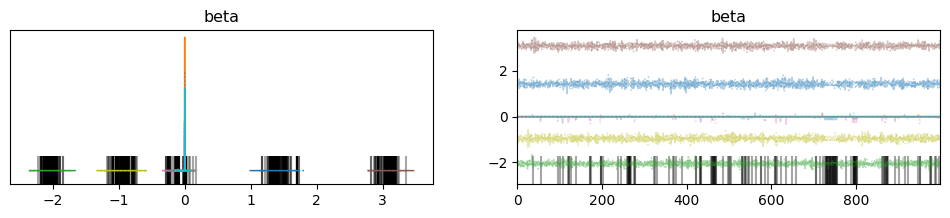

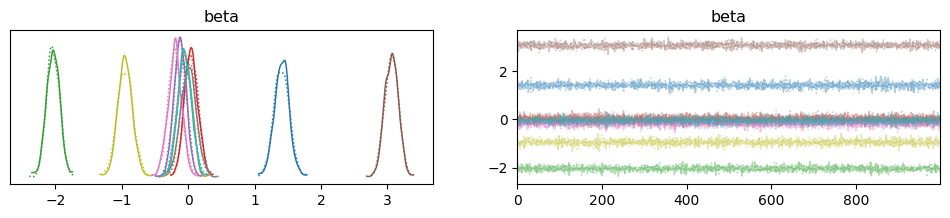

In [5]:
import numpy as np
import pymc as pm
import arviz as az

# Simulated Data
np.random.seed(42)
n, p = 100, 10
X = np.random.randn(n, p)
beta_true = np.array([1.5, 0, -2, 0, 0, 3, 0, 0, -1, 0])  # Sparse true coefficients
y = X @ beta_true + np.random.randn(n)

# Spike-and-Slab Model
with pm.Model() as spike_slab:
    p_incl = pm.Beta("p_incl", 1, 1)
    spike = pm.Bernoulli("spike", p=p_incl, shape=p)
    slab = pm.Normal("slab", 0, 10, shape=p)
    beta = pm.Deterministic("beta", spike * slab)

    mu = pm.math.dot(X, beta)
    sigma = pm.HalfCauchy("sigma", 1)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    trace_spike_slab = pm.sample()

# Diffuse Normal Prior Model
with pm.Model() as normal_prior:
    beta = pm.Normal("beta", 0, 10, shape=p)
    mu = pm.math.dot(X, beta)
    sigma = pm.HalfCauchy("sigma", 1)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    trace_normal = pm.sample()

# Compare Results
az.plot_trace(trace_spike_slab, var_names=["beta"])
az.plot_trace(trace_normal, var_names=["beta"])


### Comparison

- **Spike-and-Slab:**  
  - Selects **only relevant predictors**.  
  - Provides **sparser solutions**.  
  - **Computationally heavier** due to discrete Bernoulli priors.  

- **Diffuse Normal Prior:**  
  - Retains **all predictors** but shrinks weak ones.  
  - **Computationally faster** but **less interpretable** for variable selection.  


### Q3 Variable Selection

Perform multivarite regression (or multivariate probit classification) with the horseshoe variable selection prior and compare inference to analagous inference with spike and slab priors.

The horseshoe variable selection prior is introduced here
- https://www.pymc.io/projects/docs/en/v5.6.0/learn/core_notebooks/pymc_overview.html
- and searches for "horseshoe prior pymc" on google produce additional examples



### The Horseshoe prior

The [PyMC overview](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html) and [many](https://www.google.com/search?q=pymc+horseshoe&oq=pymc+horseshoe) other [resources](https://mellorjc.github.io/HorseshoePriorswithpymc3.html) provide ***Horseshoe prior*** [[1]](https://www.jstor.org/stable/25734098) [[2]](https://faculty.mccombs.utexas.edu/carlos.carvalho/Carvalhoetal2009.pdf) implementations

| Half-Cauchy $\text{HC}_+(\xi)$ | Horseshoe Prior $\text{HSP}$ | Shrinkage $\kappa$ | Change of Variables|
|:-:|:-:|:-:|:-:|
|$$f(x \mid \xi) = \frac{2\cdot 1_{[x>=0]}(x)}{\pi \xi \left[1 + \left(\frac{x}{\xi}\right)^2\right]}$$|\begin{align*}w_i|\tau &\sim N(0, \sigma^{2}=\lambda_i^2\tau^2)\\\lambda_i &\sim HC_+(1)\\\tau &\sim HC_+(\tau_0)\end{align*}|\begin{align*}\kappa_{\lambda_i} ={}& 1/(1+\lambda_i^2)\\\lambda_i ={}& \sqrt{1/\kappa_{\lambda_i}-1}\\J_{\kappa_{\lambda_i}} ={}& \frac{1}{2}(\kappa_{\lambda_i}^{-1}-1)^{-\frac{1}{2}}\times \kappa_{\lambda_i}^{-2} \end{align*}|\begin{align*}f(\kappa_{\lambda_i}) = {} & f\left(\lambda_i = \sqrt{1/\kappa_{\lambda_i}-1}\right)\\ {} & \times \underbrace{\frac{1}{2}(\kappa_{\lambda_i}^{-1}-1)^{-\frac{1}{2}}\times \kappa_{\lambda_i}^{-2}}_{J_{\kappa_{\lambda_i}}} \end{align*}|



Output()

ERROR:pymc.stats.convergence:There were 445 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


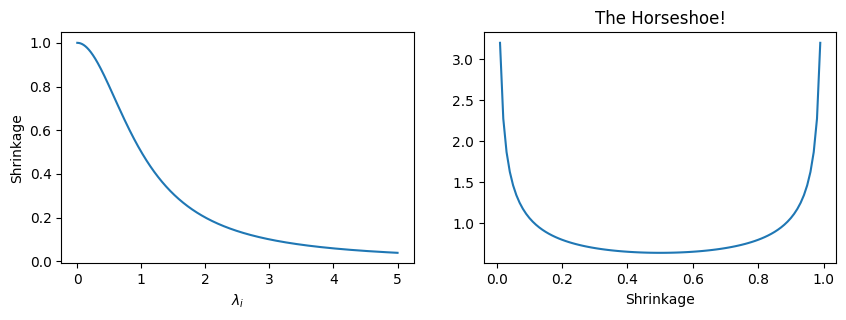

In [6]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import scipy.stats as stats

# Simulated Data
np.random.seed(42)
n, p = 100, 10
X = np.random.randn(n, p)
beta_true = np.array([1.5, 0, -2, 0, 0, 3, 0, 0, -1, 0])  # Sparse true coefficients
y = X @ beta_true + np.random.randn(n)

# Horseshoe Prior Model
with pm.Model() as horseshoe:
    tau = pm.HalfCauchy("tau", beta=1)
    lam = pm.HalfCauchy("lam", beta=1, shape=p)
    beta = pm.Normal("beta", mu=0, sigma=tau * lam, shape=p)

    mu = pm.math.dot(X, beta)
    sigma = pm.HalfCauchy("sigma", 1)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    trace_horseshoe = pm.sample()

# Visualization of Shrinkage Effect
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
support = np.linspace(0, 5, 1000)
shrinkage = 1 / (1 + support**2)
ax[0].plot(support, shrinkage)
ax[0].set_ylabel("Shrinkage")
ax[0].set_xlabel("$\\lambda_i$")
shrinkage = np.linspace(0.01, 0.99, 99)
ax[1].plot(
    shrinkage,
    stats.halfcauchy(scale=1).pdf((1 / shrinkage - 1) ** 0.5)
    * 0.5
    * (1 / shrinkage - 1) ** (-0.5)
    * shrinkage ** (-2),
)
ax[1].set_title("The Horseshoe!")
ax[1].set_xlabel("Shrinkage")
plt.show()


### Comparison

- **Horseshoe Prior:**  
  - Provides **continuous shrinkage**, preventing over-penalization.  
  - Efficient for **high-dimensional problems**.  
  - **Computationally faster** than Spike-and-Slab.  

- **Spike-and-Slab Prior:**  
  - **Enforces sparsity strictly** (binary selection).  
  - Can be computationally expensive in **large-scale models**.  
